In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
from sklearn.preprocessing import OneHotEncoder
import torch
import transformers
from transformers import DistilBertTokenizer, DistilBertModel, TFDistilBertForTokenClassification, TFDistilBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Download and load the spaCy model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/Dataset/Laptop_Train_v2.csv"
data = pd.read_csv(file_path)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74,86
2,1316,The tech guy then said the service center does...,service center,negative,27,41
3,1316,The tech guy then said the service center does...,"""sales"" team",negative,109,121
4,1316,The tech guy then said the service center does...,tech guy,neutral,4,12


In [ ]:
data = data.drop(columns = ['id', 'from', 'to'], axis = 1)
data.head()

,Sentence,Aspect Term,polarity
0,I charge it at night and skip taking the cord ...,cord,neutral
1,I charge it at night and skip taking the cord ...,battery life,positive
2,The tech guy then said the service center does...,service center,negative
3,The tech guy then said the service center does...,"""sales"" team",negative
4,The tech guy then said the service center does...,tech guy,neutral


In [ ]:
def str_to_num(x):
    if x == 'psotive':
      return 1
    elif x == 'negative':
      return 2
    else:
      return 0

data['polarity'] = data['polarity'].apply(str_to_num)
data.head()


,Sentence,Aspect Term,polarity
0,I charge it at night and skip taking the cord ...,cord,0
1,I charge it at night and skip taking the cord ...,battery life,0
2,The tech guy then said the service center does...,service center,2
3,The tech guy then said the service center does...,"""sales"" team",2
4,The tech guy then said the service center does...,tech guy,0


Gensim is a pyhtoon library that helps in creating the vector representation of texts & also helps in computing document similarity and perform semantic search. It can also help in tokenization, removing stop words. It contains popular models like W2V, FastTex, Glove, BOW, TfIdf.

In [ ]:
pip install gensim

In [ ]:
#this function takes a sentence as an argumente and returns the tokens or words by splitting the sentence using space and comma.
def splitSentence(sentence):
  split_sentence = sentence.split(",") # split by commas
  split_sentence = [word.split() for word in split_sentence] # split each word by space
  split_sentence = [word for sublist in split_sentence for word in sublist] # flatten the list of lists

  return split_sentence

In [ ]:
import gensim.downloader as api

# Download the pre-trained Word2Vec model from Google
w2v_model = api.load('word2vec-google-news-300')

# Define the function to split sentences into words/tokens using Word2Vec
import gensim.downloader as api

# Download the pre-trained Word2Vec model from Google
w2v_model = api.load('word2vec-google-news-300')

# Define the function to split sentences into words/tokens using Word2Vec
def split_sentence(sentence):
    words = []
    for word in splitSentence(sentence):
        if word in w2v_model:
            words.append(word)
    return words

def word2vec(sentence):
    words = splitSentence(sentence)

    # Get the word vectors for the words in the sentence
    vectors = [w2v_model[word] for word in words]
    return words,vectors

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification , AutoTokenizer , AutoModelForSequenceClassification

# Load the pre-trained BERT model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)




# Define your training data
sentences = list(data['Sentence'][:1200])
aspect_terms = list(data['Aspect Term'][:1200])
labels = list(data['polarity'][:1200])
# Tokenize the sentences and aspect terms
inputs = tokenizer(sentences, aspect_terms, padding=True, truncation=True, max_length=90, return_tensors='pt')


# Create a PyTorch Dataset
dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels))

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
model.train()
num_epochs=5
batch_size = 32
for epoch in range(num_epochs):
    i = 0
    for batch in torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True):
        input_ids, attention_mask, label_ids = batch
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=label_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        i = i + 1
    print("num_epochs = ",epoch,"and loss=",loss.item())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_epochs =  5 and loss= 0.5677675008773804
num_epochs =  5 and loss= 0.12051831185817719
num_epochs =  5 and loss= 0.1981513947248459
num_epochs =  5 and loss= 0.5264280438423157
num_epochs =  5 and loss= 0.043099839240312576


In [ ]:
torch.save(model.state_dict(), 'bert-finetune.pt')

In [ ]:
# Use the model to predict the sentiment polarity for new data
new_sentences = list(data['Sentence'][1200:])
new_aspect_terms = list(data['Aspect Term'][1200:])
model.eval()
with torch.no_grad():
    inputs = tokenizer(new_sentences, new_aspect_terms, padding=True, truncation=True, max_length=128, return_tensors='pt')
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    predictions = torch.argmax(outputs.logits, dim=-1)


In [ ]:
c = 0
actual = list(data['polarity'][1200:])

True Positives (TP):  301
True Negatives (TN):  656
False Positives (FP):  82
False Negatives (FN):  119


<Axes: >

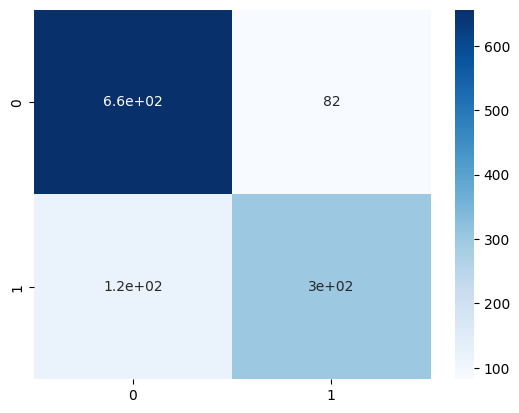

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(actual, predictions)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP

# print results
print("True Positives (TP): ", TP)
print("True Negatives (TN): ", TN)
print("False Positives (FP): ", FP)
print("False Negatives (FN): ", FN)

# create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap="Blues")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
class_weights = {0: 1, 1: 0.58, 2: 1}
precision = precision_score(actual, predictions,average='weighted',sample_weight=[class_weights[label] for label in actual])
recall = recall_score(actual, predictions,average='weighted',sample_weight=[class_weights[label] for label in actual])
f1 = f1_score(actual, predictions,average='weighted',sample_weight=[class_weights[label] for label in actual])

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)

Precision:  0.8244901721107979
Recall:  0.8264248704663213
F1 Score:  0.8245483076706378
Accuracy:  0.8264248704663213


In [ ]:
print(predictions)

tensor([0, 0, 0,  ..., 2, 2, 0])


In [ ]:
# Get the aspect terms from the test set (the part of the data used for prediction)
test_aspect_terms = list(data['Aspect Term'][1200:])

# Create a DataFrame with predicted labels and corresponding aspect terms
predicted_results = pd.DataFrame({'Aspect Term': test_aspect_terms, 'Predicted Polarity': predictions.tolist()})

# Filter the DataFrame for predicted negative polarity (label 2)
predicted_negative_aspects_df = predicted_results[predicted_results['Predicted Polarity'] == 2]

# Group by 'Aspect Term' and count occurrences
predicted_aspect_counts = predicted_negative_aspects_df['Aspect Term'].value_counts().reset_index()
predicted_aspect_counts.columns = ['Aspect Term', 'Predicted Negative Count']

# Sort by count in descending order
most_predicted_negative_aspects = predicted_aspect_counts.sort_values(by='Predicted Negative Count', ascending=False)

# Display the result
display(most_predicted_negative_aspects.head())

,Aspect Term,Predicted Negative Count
0,battery,18
1,screen,14
2,hard drive,12
3,charge,10
4,keyboard,8
